### Classification

**COMP4670/8600 &mdash; Statistical Machine Learning &mdash; Week 4**

In this lab we will build, train, and test a logistic regression classifier.

### Assumed knowledge:

- Optimisation in Python (week 1 lab)
- Regression (week 2 lab)
- Binary classification with logistic regression (week 3 lectures)

### After this lab, you should be comfortable with:

- Implementing logistic regression
- Practical binary classification problems

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt

%matplotlib inline

## The data set

We will be working with the census-income dataset, which shows income levels for people in the 1994 US Census. We will predict whether a person has $\leq \$50000$ or $> \$50000$ income per year.

The data are included with this notebook as `04-dataset.tsv`, a textfile where in each row of data, the individual entries are delimited by tab characters. Download the data from the [course website](https://machlearn.gitlab.io/sml2019/tutorials/04-dataset.tsv)
Load the data into a NumPy array called `data` using `numpy.genfromtxt`:

```python
    numpy.genfromtxt(filename)
```

The column names are given in the variable `columns` below.
The `income` column are the targets, and the other columns will form our data used to try and guess the `income`

In [65]:
columns = ['income', 'age', 'education', 'private-work', 'married', 'capital-gain', 'capital-loss', 'hours-per-week']

In [66]:
data = np.genfromtxt("04-dataset.tsv")

## Recap - Binary classification

The idea behind this lab is that for each person, we want to
try and predict if their income is above the threshold of $\$50,000$ or not,
based on a series of other data about their person: `age, education,...`.

As per usual, for the $n^\text{th}$ row, the first entry is the target $t_n$, and the rest
forms the data vector $\mathbf{x}_n$

We have two classes, $C_1$ representing the class of $ <\$ 50,000$, which corresponds to
a target of $t_n = 0$, and $C_2$, representing the class of $ >\$50,000$, corresponding to
a target of $t_n = 1$. Our objective is to learn a discriminative function $f_{\mathbf{w}}(\mathbf{x})$,
parametrised by a weight vector $\mathbf{w}$ that
predicts which income class the person is in, based on the data given.

We assume that each piece of information $(t_n, \mathbf{x}_n)$ is i.i.d, and
that there is some hidden probability distribution from which these target/data points are drawn.
We will construct a likelihood function that indicates ``what is the likelihood that of this particular
weight vector $\mathbf{w}$, given that we have observed the training data $(t_n, \mathbf{x}_n)$?''.
$\{t_1, t_2, \ldots \}$ would be generated?"

## Recap - Feature map, basis function

Now some classes are not linearly seperable (we cannot draw a line such that all of one class is on one side,
and all of the other class is on the other side). But by applying a fixed non-linear 
transformation to the inputs $\mathbf{x}_i$ first, the result is usually linearly, for a suitable choice
of transformation $\phi$. (See week 3, pg 342 of the lecture slides).

We let
$$
\mathbf{\phi}_n := \phi(\mathbf{x}_n)
$$

The result is linear in $\phi$ but not in $\mathbf{x}$, so we work in feature space rather than
input space.
For the case of two classes, we could guess that the target is a linear combination of the features,
$$
\hat{t}_n = \mathbf{w}^T \mathbf{\phi}_n
$$
but $\mathbf{w}^T \mathbf{\phi}_n$ is a real number, and we want $\hat{t}_n \in \{0,1\}$.
We could threshold the result,
$$
\hat{t}_n =
\begin{cases}
1 & \mathbf{w}^T \mathbf{\phi}_n \geq 0 \\
0 & \mathbf{w}^T \mathbf{\phi}_n < 0
\end{cases}
$$
but the discontinuity makes it impossible to define a sensible gradient. 

## Recap - Logistic Regression

(We assume that the classes are already linearly seperable, and use our input space as our feature space.
We also assume the data is i.i.d).

Instead of using a hard threshold like above, in logistic regression
we can use the sigmoid function $\sigma(a)$
$$
\sigma(a) := \frac{1}{1 + e^{-a}}
$$
which has the intended effect of "squishing" the real line to the interval $[0,1]$.
This gives a smooth version of the threshold function above, that we can differentiate.
The numbers it returns can be interpreted as a probability of the estimated target $\hat{t}$ belonging
to a class $C_i$ given the element $\phi$ of feature space. In the case of two classes, we define
\begin{align}
p(C_1 | \phi ) &:= \sigma (\mathbf{w}^T \phi) \\
p(C_2 | \phi ) &:= 1 - p(C_1 | \phi)
\end{align}



The likelihood function $p(\mathbf{t} | \mathbf{w}, \mathbf{x})$ is what we want to maximise as a function
of $\mathbf{w}$. Since $\mathbf{x}$ is fixed, we usually write the likelihood function as $p(\mathbf{t} | \mathbf{w})$.

$$
\begin{align}
p(\mathbf{t} | \mathbf{w})
&= \prod_{i=1}^n p(t_i | \mathbf{w}) \\
&= \prod_{i=1}^n 
\begin{cases}
p(C_1 | \phi_i) & t_i = 1 \\
p(C_2 | \phi_i) & t_i = 0
\end{cases}
\end{align}
$$
Note that
$$
\begin{cases}
 y_n & t_i = 1 \\
1 - y_n & t_i = 0
\end{cases}
= y_n^{t_n} (1-y_n)^{1-t-n}
$$
as if $t_n = 1$, then $y_n^1 (1-y_n)^{1-1} = y_n$ and if $t_n = 0$ then $y_n^0 (1-y_n)^{1-0} = 1-y_n$.
This is why we use the strange encoding of $t_i=0$ corresponds to $C_2$ and $t_i=1$ corresponds to $C_1$.
Hence, our likelihood function is 
$$
p(\mathbf{t} | \mathbf{w}) = \prod_{i=1}^N y_n^{t_n} (1-y_n)^{1-t-n}, \quad y_n = \sigma(\mathbf{w}^T \phi_n)
$$
This function is quite unpleasant to try and differentiate, but we note that $p(\mathbf{t} | \mathbf{w})$
is maximised when $\log p(\mathbf{t} | \mathbf{w})$ is maximised.
\begin{align}
\log p(\mathbf{t} | \mathbf{w}) 
&= \log \prod_{i=1}^N y_n^{t_n} (1-y_n)^{1-t-n} \\
&= \sum_{i=1}^N \log \left( y_n^{t_n} (1-y_n)^{1-t-n} \right) \\
&= \sum_{i=1}^N \left( t_n \log y_n +  (1-t_n) \log (1-y_n) \right)
\end{align}
Which is maximised when $- \log p(\mathbf{t} | \mathbf{w})$ is minimised, giving us our error function.
$$
E(\mathbf{w}) := - \sum_{i=1}^N \left( t_n \log y_n +  (1-t_n) \log (1-y_n) \right)
$$
We can then take the derivative of this. As an exercise, you should do this (using the identity $\sigma'(a) = \sigma(a) \left( 1- \sigma(a) \right)$ to simplify).
$$
\nabla_\mathbf{w} E(\mathbf{w}) = \sum_{i=1}^N (y_n - t_n) \phi_n
$$
which you will note doesn't have any sigmoid functions.

(We also usually divide the error by the number of data points, to obtain the average error. The error
shouldn't get 10 times as large just because there is more data avaliable, so we should divide by the
number of error points to reflect that.)

## Recap - $L_2$ regularisation, Gaussian prior

To help avoid overfitting, we can add a penalty term to the cost function of the form 
$\frac{\lambda}{2} ||\mathbf{w}||^2$. By tweaking the value of $\lambda$, we can indicate how
much to penalise large terms in the weight vector $\mathbf{w}$. Don't forget to take the regularistion term into
account when you compute the corresponding gradient $\nabla_\mathbf{w} E(\mathbf{w})$.


## Explain logistic regression (10 minutes)

Find a partner in your lab (or groups of 3). Take turns to explain the topics above to each other, without referring to the lab sheet. Be as precise as possible, by writing down the relevant equations.


## Classification with logistic regression

Implement binary classification using logistic regression and $L_2$ regularisation. Make sure you write good quality code with comments and docstrings where appropriate.

Use ```scipy.optimize.fmin_bfgs``` to optimise your cost function. ```fmin_bfgs``` takes as arguments the cost function to be optimised, and a tuple of extra arguments to the cost function:

```python
    scipy.optimise.fmin_bfgs(cost_function, initial_guess, args=())
```

By following equations in lectures, implement three functions:

- `grad(w, X, t, a)`, which calculates the gradient of the cost function,
- `train(X, t, a)`, which returns the maximum likelihood weight vector, and
- `test(w, X)`, which returns predicted class probabilities,

where 
* $w$ is a weight vector, 
* $X$ is a matrix of examples, 
* $t$ is a vector of labels/targets, 
* $a$ is the regularisation weight. 

(We would use $\lambda$ for the regularisation term, but `a` is easier to type than `lambda`, and
`lambda` is a reserved keyword in python, for lambda functions).

See below for expected usage.

We add an extra column of ones to represent the bias term.

## Note

* You should use 80% of the data as your training set, and 20% of the data as your test set.
* You also may want to normalise the data before hand. If the magnitude of $\mathbf{w}^T \phi_n$
is very large, the gradient of $\sigma(\mathbf{w}^T \phi_n)$ will be very near zero, which can
cause convergence issues during numerical minimisation. If each element in a particular column is
multiplied by a scalar (say, all elements of the `age` column) then the result is essentially the same
as stretching the space in which the data lives. The model will also be proportionally stretched,
but will not fundamentally change the behaviour. So by normalising each column, we can avoid
issues related to numerical convergence.

In [67]:
assert data.shape[1] == 8, 'you already ran this cell!'
data = np.concatenate([data, np.ones((data.shape[0], 1))], axis=1)  # add a column of ones
data.shape

(32561, 9)

In [68]:
# solution

import scipy.special

def sigmoid(a):
    return 1 / (1 + np.exp(-a))

def train(X, t, a):
    fprime = grad
    return opt.fmin_bfgs(
        f=cost, fprime=fprime, x0=np.random.normal(scale=0.2, size=(X.shape[1],)), args=(X, t, a), disp=0)

def test(w, X):
    return sigmoid(X @ w)

def cost(w, X, t, a):
    # binary cross-entropy loss is
    # t log y + (1 - t) log (1 - y)
    y = test(w, X)
    mask = (y > 0) & (y < 1)
    t = t[mask]
    y = y[mask]
   # print("Mask is : ", y)
    # regularisation L2 penalty
    l2 = (w**2).sum() * a / 2
    likelihood = t @ np.log(y) + (1 - t) @ np.log(1 - y)
    cost = l2 - likelihood
    return cost


# def grad(w, X, t, a):
#     y = test(w, X)
#   #  print("Shape of X and y is : ",np.shape(X) , " y is : ",np.shape(y) ,"t is : ", np.shape(t))
#     print("Shape of the gradient is : ", (X * (y - t)[:, None]).sum(axis=0) + a * w)
#     return (X * (y - t)[:, None]).sum(axis=0) + a * w
def grad(w, X, t, a):
    y = test(w, X)
  #  print("Shape of X and y is : ",np.shape(X) , " y is : ",np.shape(y) ,"t is : ", np.shape(t))
    #print("Shape of the gradient is : ", (X * (y - t)[:, None]).sum(axis=0) + a * w)
    return (X * (y - t)[:, None]).sum(axis=0) + a * w


In [69]:
# solution 

N = np.shape(data)[0]
num_train = int(0.8*N)
y_train = data[:num_train,0]
y_test = data[num_train:, 0]
#32561
norm_data = data[:, 1:] / data[:, 1:].sum(axis=0, keepdims=True)
X_train = norm_data[:num_train, 1:]
X_test = norm_data[num_train:, 1:]


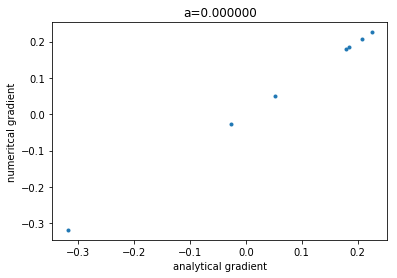

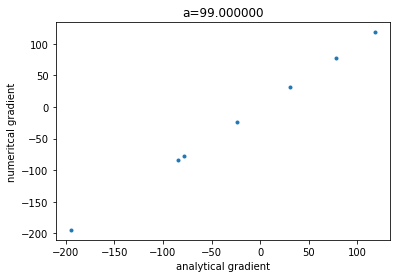

In [74]:
# solution

# triangulate the implementation of grad() and cost():

def numerical_grad(f, x, *args):
    eps = 1e-5
    fx = f(x, *args)
    grad = np.zeros_like(x)
    for i in range(len(x)):
        xi = x.copy()
        xi[i] += eps
        fxi = f(xi, *args)
        grad[i] = (fxi-fx) / eps
    return grad

w = np.random.randn(X_train.shape[1])
for a in (0, 99):
    ga = grad(w, X_train, y_train, a)
    gn = numerical_grad(cost, w, X_train, y_train, a)
    plt.figure()
    plt.plot(ga, gn, '.')
    plt.xlabel('analytical gradient')
    plt.ylabel('numeritcal gradient')
    plt.title('a=%f' % a)
    assert np.allclose(ga, gn, rtol=1e-2, atol=1e-2), list(zip(ga, gn))
del a, w

In [79]:
# solution

w_train = train(X_train, y_train, 1e-1) #tweak regularisation parameter so weights are not big
y_guess = test(w_train, X_test)
# print(y_guess)
print(w_train)

[-1.79389052 -2.25881079 -0.51415338  3.17457224  0.26087605 -1.84469167
 -2.08285926]


In [86]:
y_test


array([0., 0., 1., ..., 0., 0., 1.])

## Performance measure

There are many ways to compute the performance of a binary classifier. The key concept is the idea of a confusion matrix:

|     &nbsp;         | &nbsp;  | Label | &nbsp;  |
|:-------------:|:--:|:-----:|:--:|
|     &nbsp;         |  &nbsp;  |  0    | 1  |
|**Prediction**| 0  |    TN | FN |
|      &nbsp;        | 1  |    FP | TP |

where
* TP - true positive
* FP - false positive
* FN - false negative
* TN - true negative

Implement three functions:

- `confusion_matrix(y_true, y_pred)`, which returns the confusion matrix as a list of lists given a list of true labels and a list of predicted labels;
- `accuracy(cm)`, which takes a confusion matrix and returns the accuracy; and
- `balanced_accuracy(cm)`, which takes a confusion matrix and returns the balanced accuracy.

The accuracy is defined as $\frac{TP + TN}{n}$, where $n$ is the total number of examples. The balanced accuracy is defined as $\frac{1}{2}\left(\frac{TP}{P} + \frac{TN}{N}\right)$, where $T$ and $N$ are the total number of positive and negative examples respectively.

In [87]:
# solution
def confusion_matrix(y_true, y_pred):
    y_pred = y_pred > 0.5
    y_true = y_true > 0.5
    tp = ((y_true == y_pred) & (y_true)).sum()
    tn = ((y_true == y_pred) & (~y_true)).sum()
    fp = ((y_true != y_pred) & (~y_true)).sum()
    fn = ((y_true != y_pred) & (y_true)).sum()
    return [[tn, fn], [fp, tp]]

def accuracy(cm):
    (TN, FN), (FP, TP) = cm
    return (TN + TP) / (TN + FN + FP + TP)

def balanced_accuracy(cm):
    (TN, FN), (FP, TP) = cm
    return (TN / (TN + FP) + TP / (TP + FN)) / 2

## Accuracy vs balanced accuracy

What is the purpose of balanced accuracy? When might you prefer it to accuracy?

### solution
Balanced accuracy accounts for class imbalance. In the extreme case, you would use it if you have imbalanced classes.
For example, suppose you had some model that you were trying to learn if a patient had cancer based on
MRI scan data, and the prior probability on any one person having cancer is 0.1%.
Out of thousands of training examples, only a handful might actually have cancer. By just making the model always
say "no, this person doesn't have cancer" it's already 99.9% accurate. During training, the model may just 
naturally do this, by overfitting to the cases where cancer was not present.
But the penalty for a false positive 
(the model says you have cancer when you don't) is far less bad than a false negative (the model says you are okay when you do have cancer). So we need our accuracy to be weighted by the number of training examples.

## Putting everything together

Consider the following code, which trains on all the examples, predicts on the training set, and then computes the accuracy and balanced accuracy. Discuss the results.

In [88]:
# solution

cmatrix = confusion_matrix(y_guess, y_test)
[accuracy(cmatrix), balanced_accuracy(cmatrix)]

#print(cmatrix)

[0.7859665284814985, 0.7555762338020402]

### solution
We get higher accuracy than balanced accuracy. This means that our data are class-imbalanced, and logistic regression may be over-fitting.

## Looking back at the prediction task

Based on your results, what feature of the dataset is most useful for determining the income level? What feature is least useful? Why?

['income', 'age', 'education', 'private-work', 'married', 'capital-gain', 'capital-loss', 'hours-per-week'] [-1.79389043 -2.25881083 -0.51415332  3.17457224  0.26087606 -1.84469165
 -2.08285926]


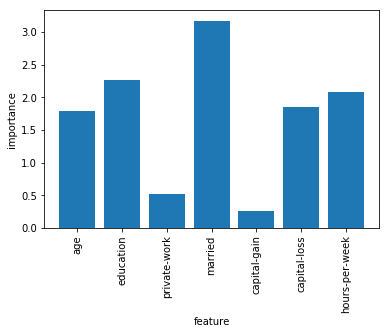

In [11]:
# solution
plt.bar(range(len(w_train)), abs(w_train))
plt.ylabel('importance')
plt.xlabel('feature')
plt.xticks(range(len(w_train)), columns[1:] + ['bias'], rotation='vertical');
print(columns,w_train)

### solution

The most important feature is **married** because it has the highest weight. (we ignore the bias term, as it just helps to shift the logistic regressor to help seperate the two classes. It doesn't actually correspond to any input data.